In this Notebook, we aim at creating some DataDriven surrogate models for the simpliest 1D Poisson Equation: 

$$
- D \Delta u = 1
$$

with D the diffusion coefficient, considerer as scalar and constant over the whole domain. 

Our goal is to create params to solutions models, i.e a mapping from D to u.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use an implicit finite difference method. 
$$
-D \frac{u_{i-1} -2u_i + u_{i+1}}{(\Delta x)^2} = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_1.py file 

In [4]:
from solvers.Solver import Solver
from config_step_1 import PARAMS_SOLVER

Poisson equation in a \[0, 1\] domain and 101 points for discretizations

In [5]:
PARAMS_SOLVER

{'equation': 'Poisson', 'domain': [0.0, 1.0], 'D': 1.0, 'nx': 101}

In [6]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = Solver(params={'solver': params_solver})

In [7]:
u = solver.solve()

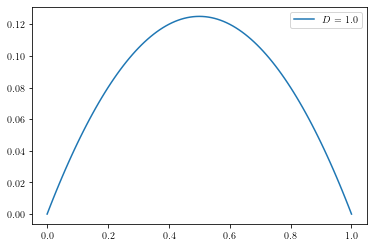

In [8]:
plt.plot(solver.x, u, label=f'$D$ = {solver.D}')
plt.legend()
plt.show()

Now let us generate a dataset using this solver

In [9]:
Dmin, Dmax = 0.1, 10
D_list = np.linspace(Dmin, Dmax, 1000).reshape(-1, 1)

In [10]:
U_sols = []
for d in D_list:
    solver.change_D(d)
    U_sols.append(solver.solve())
    
U_sols = np.stack(U_sols)

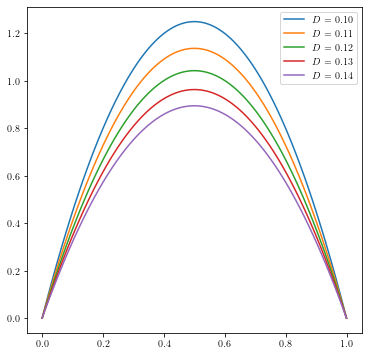

In [11]:
fig, axs = plt.subplots(1, figsize=(6, 6))
for sample in range(0, 5):
    axs.plot(solver.x, U_sols[sample, :], label=f'$D$ = {D_list[sample, 0]:.2f}')
plt.legend(loc=1)
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [12]:
from methods.DataDrivenMethods import DDMethod

In [13]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO'] 

Best hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them 

In [14]:
from config_step_1 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [15]:
PARAMS_METHODS['DEEPONET']

{'method_name': 'DEEPONET',
 'branch': {'layer_dims': [1, 22, 9, 21, 32, 19],
  'activations': 'tanh',
  'device': 'cpu',
  'seed': 123},
 'trunk': {'layer_dims': [1, 13, 19],
  'activations': 'tanh',
  'device': device(type='cuda'),
  'seed': 123}}

In [16]:
HYPERPARAMS_METHODS['DEEPONET']

{'lr': 0.0004, 'epochs': 20000, 'optimizer': 'Adam', 'device': 'cpu'}

Create DDMethod object for each method

In [17]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

Data preparation for training 

In [18]:
d_train, d_val, u_train, u_val = sklearn.model_selection.train_test_split(D_list, U_sols, test_size=0.2, random_state=123)

In [19]:
nx = PARAMS_SOLVER['nx']
D_train_repeated = torch.Tensor(d_train.repeat(nx, 1).reshape(-1, 1))
D_val_repeated = torch.Tensor(d_val.repeat(nx, 1).reshape(-1, 1))

In [20]:
x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(d_train.shape[0], 1)
X_val = x.repeat(d_val.shape[0], 1)

In [21]:
DX_train = torch.cat((D_train_repeated, X_train), dim=1)
DX_val = torch.cat((D_val_repeated, X_val), dim=1)
U_train = torch.Tensor(u_train).view(-1, 1)
U_val = torch.Tensor(u_val).view(-1, 1)

Fit all methods using fit function on DDMethod object

In [22]:
D_fno_train = torch.Tensor(d_train.repeat(nx, 1)).unsqueeze(-1)
D_fno_val = torch.Tensor(d_val.repeat(nx, 1)).unsqueeze(-1)

In [23]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=U_sols)
    elif method in ['MLP']:
        all_methods[method].fit(hyperparameters=hyperparams_method, U_train=U_train, U_val=U_val, DX_train=DX_train, DX_val=DX_val, 
                                data_ratio=1., physics_ratio=0.)
        # all_methods[method].load_state_dict('optuna/step_1/MLP.pt')
    elif method == 'DEEPONET':
        all_methods[method].fit(hyperparameters=hyperparams_method, U_train=u_train, U_val=u_val, D_train=d_train, D_val=d_val)
        # all_methods[method].load_state_dict('optuna/step_1/DEEPONET.pt')
        
    elif method == 'PINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                 DX_train=DX_train, DX_val=DX_val, U_val=U_val, data_ratio=0., physics_ratio=1.)
        # all_methods[method].load_state_dict('optuna/step_1/PINN.pt')
    elif method == 'MLPINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, DX_train=DX_train, DX_val=DX_val, U_train=U_train, U_val=U_val,
                           data_ratio=1., physics_ratio=1.)
        # all_methods[method].load_state_dict('optuna/step_1/MLPINN.pt')
        
    elif method == 'FNO':
        all_methods[method].fit(hyperparameters=hyperparams_method, D_train=D_fno_train, D_val=D_fno_val, U_train=u_train, U_val=u_val)
        # all_methods[method].load_state_dict('optuna/step_1/FNO.pt')

Fitting POD
POD fitted
Fitting MLP


[tr : 3.3e-06, val : 5.1e-06]: 100%|█████| 20000/20000 [01:12<00:00, 275.96it/s]


MLP fitted
Fitting DEEPONET


[tr : 3.6e-06, val : 3.3e-06]: 100%|█████| 20000/20000 [00:36<00:00, 544.01it/s]


DEEPONET fitted
Fitting PINN


[tr : 6.6e-06, val : 1.4e-06]: 100%|██████| 20000/20000 [04:59<00:00, 66.87it/s]


PINN fitted
Fitting MLPINN


[tr : 7.7e-06, val : 1.1e-06]: 100%|██████| 20000/20000 [05:36<00:00, 59.45it/s]


MLPINN fitted
Fitting FNO


[epoch: 20000 : 100%|█████████████████████| 20001/20001 [07:19<00:00, 45.52it/s]

FNO fitted


In [28]:
for method in all_methods:
    if method in ['MLP', 'PINN', 'DEEPONET', 'FNO', 'MLPINN']:
        torch.save({'model_state_dict': all_methods[method].state_dict,
             'loss_dict': all_methods[method].loss_dict(),
             }, f'optuna/step_1/{method}.pt')

# torch.save(all_methods['MLP'].state_dict(), 'optuna/step_1/MLP.pt')
# torch.save(all_methods['DEEPONET'].state_dict(), 'optuna/step_1/DONUT.pt')
# torch.save(all_methods['PINN'].state_dict(), 'optuna/step_1/PINN.pt')
# torch.save(all_methods['MLPINN'].state_dict(), 'optuna/step_1/MLPINN.pt')

# Plot performances for each method

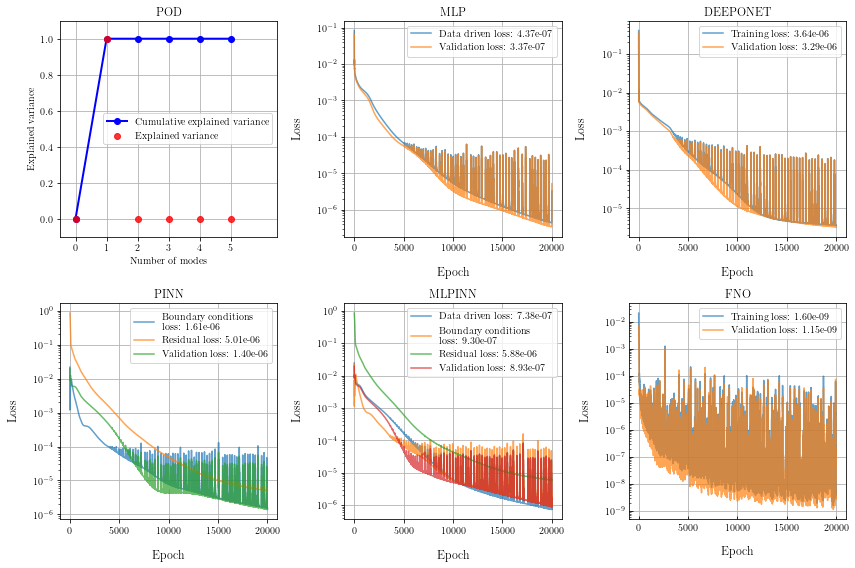

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.show()

## In distribution analysis

In [29]:
new_D = 9
solver.change_D(new_D=new_D)
U_FD = solver.solve()
U_MLP = all_methods['MLP'].apply_method([new_D])
U_POD = all_methods['POD'].apply_method(new_D)
U_DONUT = all_methods['DEEPONET'].apply_method([new_D]).flatten()
U_PINN = all_methods['PINN'].apply_method([new_D])
U_MLPINN = all_methods['MLPINN'].apply_method([new_D])
U_FNO = all_methods['FNO'].apply_method([new_D]).flatten().detach().numpy()

plt.plot(solver.x, U_FD, '--', label=f'FD (True)')

#plt.plot(solver.x, U_POD, label=f'POD: {np.linalg.norm(U_POD - U_FD, 2):.2e}')
#plt.plot(solver.x, U_MLP, label=f'MLP: {np.linalg.norm(U_MLP - U_FD, 2):.2e}')
#plt.plot(solver.x, U_FNO, label=f'FNO: {np.linalg.norm(U_FNO - U_FD, 2):.2e}')
#plt.plot(solver.x, U_DONUT, label=f'DEEPONET: {np.linalg.norm(U_DONUT - U_FD, 2):.2e}')
plt.plot(solver.x, U_PINN, label=f'PINN: {np.linalg.norm(U_PINN - U_FD, 2):.2f}')
#plt.plot(solver.x, U_MLPINN, label=f'MLPINN: {np.linalg.norm(U_MLPINN - U_FD, 2):.2f}')
plt.legend()
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

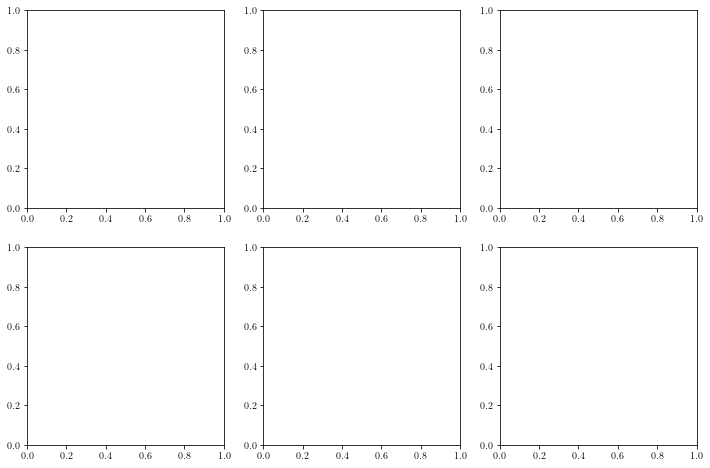

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

all_methods['POD'].parity_plot(U=U_val, D=d_val, ax=axs[0][0], label='POD', color='blue')
all_methods['MLP'].parity_plot(U=U_val, D=D_val, ax=axs[0][1], label='MLP', color='blue')
all_methods['DEEPONET'].parity_plot(U=dU_val, D=DX_val, ax=axs[0][2], label='DEEPONET', color='blue')
all_methods['PINN'].parity_plot(U=U_val, D=DX_val, ax=axs[1][0], label='PINN', color='blue')
all_methods['MLPINN'].parity_plot(U=U_val, D=DX_val, ax=axs[1][1], label='MLPINN', color='blue')
all_methods['FNO'].parity_plot(U=U_val, D=D_val, ax=axs[1][2], label='FNO', color='blue')

for ax in axs.flatten():
    ax.legend()
fig.tight_layout()
plt.show()

## Out of Distribution

In [ ]:
new_D = 11.
solver.change_D(new_D=new_D)
U_FD = solver.solve()
U_MLP = all_methods['MLP'].apply_method([new_D])
U_POD = all_methods['POD'].apply_method(new_D)
U_DONUT = all_methods['DEEPONET'].apply_method([new_D]).flatten()
U_PINN = all_methods['PINN'].apply_method([new_D])
U_MLPINN = all_methods['MLPINN'].apply_method([new_D])
U_FNO = all_methods['FNO'].apply_method([new_D]).flatten().detach().numpy()


plt.plot(solver.x, U_FD, '--', label=f'FD (True)')
plt.plot(solver.x, U_POD, label=f'POD: {np.linalg.norm(U_POD - U_FD, 2):.2e}')
plt.plot(solver.x, U_MLP, label=f'MLP: {np.linalg.norm(U_MLP - U_FD, 2):.2e}')
plt.plot(solver.x, U_DONUT, label=f'DEEPONET: {np.linalg.norm(U_DONUT - U_FD, 2):.2e}')
plt.plot(solver.x, U_PINN, label=f'PINN: {np.linalg.norm(U_PINN - U_FD, 2):.2e}')
plt.plot(solver.x, U_MLPINN, label=f'MLPINN: {np.linalg.norm(U_MLPINN - U_FD, 2):.2e}')
plt.plot(solver.x, U_FNO, label=f'FNO: {np.linalg.norm(U_FNO - U_FD, 2):.2e}')
plt.legend()
plt.show()

## Parity plot

In [ ]:
#### OUT OF DISTRIBUTION D GENERATION ######
OOD_D = np.linspace(0.01, 0.1, 101)
U_OOD_FD = []
for d in OOD_D:
    solver.change_D(new_D=d)
    U_OOD_FD.append(solver.solve())

###### MLP + POD DATA PREPARATION ########
U_OOD_FD = np.stack(U_OOD_FD)
OOD_D = torch.Tensor(OOD_D).view(-1, 1)
U_OOD_FD = torch.Tensor(U_OOD_FD)

#### DEEPONET DATA PREPARATION ########
OOD_D_repeated = torch.Tensor([[d] * len(solver.x) for d in OOD_D]).view(-1, 1)
OOD_X = torch.Tensor(solver.x).view(-1, 1)
OOD_X = OOD_X.repeat(OOD_D.shape[0], 1)
OOD_DX = torch.cat([OOD_D_repeated, OOD_X], axis=1)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

all_methods['POD'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[0][0], label='POD', color='blue')
all_methods['MLP'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[0][1], label='MLP', color='blue')
all_methods['DEEPONET'].parity_plot(U=U_OOD_FD.flatten(), D=OOD_DX, ax=axs[0][2], label='DEEPONET', color='blue')
all_methods['PINN'].parity_plot(U=U_OOD_FD, D=OOD_DX, ax=axs[1][0], label='PINN', color='blue')
all_methods['MLPINN'].parity_plot(U=U_OOD_FD, D=OOD_DX, ax=axs[1][1], label='MLPINN', color='blue')
all_methods['FNO'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[1][2], label='FNO', color='blue')
for ax in axs.flatten():
    ax.legend()
plt.tight_layout()
plt.show()

## Final plot

In [ ]:
#### OUT OF DISTRIBUTION D GENERATION ######
OOD_D = np.concatenate([np.linspace(0.01, 0.1, 21), np.linspace(10, 101, 21)])
U_OOD_FD = []
for d in OOD_D:
    solver.change_D(new_D=d)
    U_OOD_FD.append(solver.solve())

###### MLP + POD DATA PREPARATION ########
U_OOD_FD = np.stack(U_OOD_FD)
OOD_D = torch.Tensor(OOD_D).view(-1, 1)
U_OOD_FD = torch.Tensor(U_OOD_FD)

#### DEEPONET DATA PREPARATION ########
OOD_D_repeated = torch.Tensor([[d] * len(solver.x) for d in OOD_D]).view(-1, 1)
OOD_X = torch.Tensor(solver.x).view(-1, 1)
OOD_X = OOD_X.repeat(OOD_D.shape[0], 1)
OOD_DX = torch.cat([OOD_D_repeated, OOD_X], axis=1)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))


all_methods['POD'].parity_plot(U=U_val, D=D_val, ax=axs[0][0], label='ID POD', color='green')
all_methods['MLP'].parity_plot(U=U_val, D=D_val, ax=axs[0][1], label='ID MLP', color='green')
all_methods['DEEPONET'].parity_plot(U=dU_val, D=DX_val, ax=axs[0][2], label='ID DEEPONET', color='green')
all_methods['PINN'].parity_plot(U=U_val, D=DX_val, ax=axs[1][0], label='ID PINN', color='green')
all_methods['MLPINN'].parity_plot(U=U_val, D=DX_val, ax=axs[1][1], label='ID MLPINN', color='green')
all_methods['FNO'].parity_plot(U=U_val, D=D_val, ax=axs[1][2], label='ID FNO', color='green')

all_methods['POD'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[0][0], label='OOD POD', color='blue')
all_methods['MLP'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[0][1], label='OOD MLP', color='blue')
all_methods['DEEPONET'].parity_plot(U=U_OOD_FD.flatten(), D=OOD_DX, ax=axs[0][2], label='OOD DEEPONET', color='blue')
all_methods['PINN'].parity_plot(U=U_OOD_FD, D=OOD_DX, ax=axs[1][0], label='OOD PINN', color='blue')
all_methods['MLPINN'].parity_plot(U=U_OOD_FD, D=OOD_DX, ax=axs[1][1], label='OOD MLPINN', color='blue')
all_methods['FNO'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[1][2], label='OOD FNO', color='blue')
for ax in axs.flatten():
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
plt.tight_layout()
plt.show()